In [ ]:
!pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
# tensorflow
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
Friday_WorkingHours_Afternoon_DDos            = pd.read_csv("data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
Friday_WorkingHours_Afternoon_PortScan        = pd.read_csv("data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
Friday_WorkingHours_Morning                   = pd.read_csv("data/Friday-WorkingHours-Morning.pcap_ISCX.csv")
Monday_WorkingHours                           = pd.read_csv("data/Monday-WorkingHours.pcap_ISCX.csv")
Thursday_WorkingHours_Afternoon_Infilteration = pd.read_csv("data/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
#Thursday_WorkingHours_Morning_WebAttacks      = pd.read_csv("data/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
Tuesday_WorkingHours                          = pd.read_csv("data/Tuesday-WorkingHours.pcap_ISCX.csv")
Wednesday_workingHours                        = pd.read_csv("data/Wednesday-workingHours.pcap_ISCX.csv")


In [3]:
df = pd.concat(
    [
        Friday_WorkingHours_Afternoon_DDos,
        Friday_WorkingHours_Afternoon_PortScan,
        Friday_WorkingHours_Morning,
        Monday_WorkingHours,
        Thursday_WorkingHours_Afternoon_Infilteration,
        #Thursday_WorkingHours_Morning_WebAttacks,
        Tuesday_WorkingHours,
        Wednesday_workingHours
    ],
    axis=0
)
#df.columns = Friday_WorkingHours_Afternoon_DDos.columns

In [4]:
#removed columns - flow id, source IP, source port , destination IP ,protocol , timestamp

In [5]:
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [6]:
df.columns

Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Pa

In [7]:
df = df.drop([ 'Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp'], axis=1)


In [8]:
df[' Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration', 'FTP-Patator',
       'SSH-Patator', 'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk',
       'DoS GoldenEye', 'Heartbleed'], dtype=object)

In [9]:
all_labels = df[' Label'].unique()
length = len(all_labels)
print(length)

12


In [10]:
#as we can see there is whitespace in column name so we have to strip it
df.columns = df.columns.str.strip()

In [11]:
df.columns

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PS

In [13]:
# df[' Label'] = df[' Label'].apply(lambda x: 'BENIGN' if x == 'BENIGN' else 'ATTACK')
# df[' Label'].unique()

In [14]:
encoder = LabelEncoder()
df['Label']= encoder.fit_transform(df['Label'])

In [15]:
df['Label'].value_counts()

Label
0     2104911
4      231073
10     158930
2      128027
3       10293
7        7938
11       5897
6        5796
5        5499
1        1966
9          36
8          11
Name: count, dtype: int64

In [16]:
df.head(5)

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3,2,0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,109,1,1,6.0,6.0,6.0,6.0,6.0,0.0,6.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,52,1,1,6.0,6.0,6.0,6.0,6.0,0.0,6.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,34,1,1,6.0,6.0,6.0,6.0,6.0,0.0,6.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,3,2,0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [17]:
df['Label'].value_counts().sum

<bound method Series.sum of Label
0     2104911
4      231073
10     158930
2      128027
3       10293
7        7938
11       5897
6        5796
5        5499
1        1966
9          36
8          11
Name: count, dtype: int64>

In [18]:
df = df.fillna(0)  # Replace NaN with 0
df = df.replace([np.inf, -np.inf], 0)

In [19]:
df.isnull().sum()

Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
Total Length of Bwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 78, dtype: int64

In [20]:
df=df.astype(int)

In [21]:

X = df.drop('Label',axis=1)
y = df['Label']




In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
# Impute missing values (replace NaNs with the mean)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Determine the number of columns (features) in your DataFrame
num_columns = df.shape[1]

# Set an appropriate value for k (less than or equal to the number of columns)
k = min(20, num_columns)  # Adjust this as needed

# Initialize SelectKBest with the scoring function
k_best = SelectKBest(score_func=f_classif, k=k)

# Fit and transform the imputed data to select the top 10 features
X_new = k_best.fit_transform(X_imputed, y)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [30 32 55 56 57 58 59 60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [24]:
# Get the boolean mask of selected features
selected_features_mask = k_best.get_support()
#l = len(selected_features_mask)
#print(l)
print(selected_features_mask)



[ True False False False False False False False False  True False  True
  True False False False  True  True False  True False  True  True False
 False False False False False False False False False False False False
 False False  True  True  True  True  True False False  True False False
 False False False  True False  True False False False False False False
 False False False False False False False False False False False False
 False  True False  True  True]


In [25]:
elected_feature_names = X.columns[selected_features_mask]

In [26]:
elected_feature_names

Index(['Flow Duration', 'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max',
       'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'PSH Flag Count', 'Average Packet Size',
       'Avg Bwd Segment Size', 'Idle Mean', 'Idle Max', 'Idle Min'],
      dtype='object')

In [28]:
# new_columns=[' Flow Duration', 'Bwd Packet Length Max', ' Bwd Packet Length Min',
#        ' Bwd Packet Length Mean', ' Bwd Packet Length Std', ' Flow IAT Std',
#        ' Flow IAT Max', 'Fwd IAT Total', ' Fwd IAT Std', ' Fwd IAT Max',
#        ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
#        ' Packet Length Std', ' Packet Length Variance', ' Average Packet Size',
#        ' Avg Bwd Segment Size', 'Idle Mean', ' Idle Max', ' Idle Min']

In [29]:
df_new = X[elected_feature_names]

In [31]:
df_new.columns

Index(['Flow Duration', 'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max',
       'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'PSH Flag Count', 'Average Packet Size',
       'Avg Bwd Segment Size', 'Idle Mean', 'Idle Max', 'Idle Min'],
      dtype='object')

In [32]:
df_new['label']=df['Label']

/var/folders/yg/vvs71ctd1tl02zyv_fxj3fjm0000gn/T/ipykernel_12997/3160568258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['label']=df['Label']


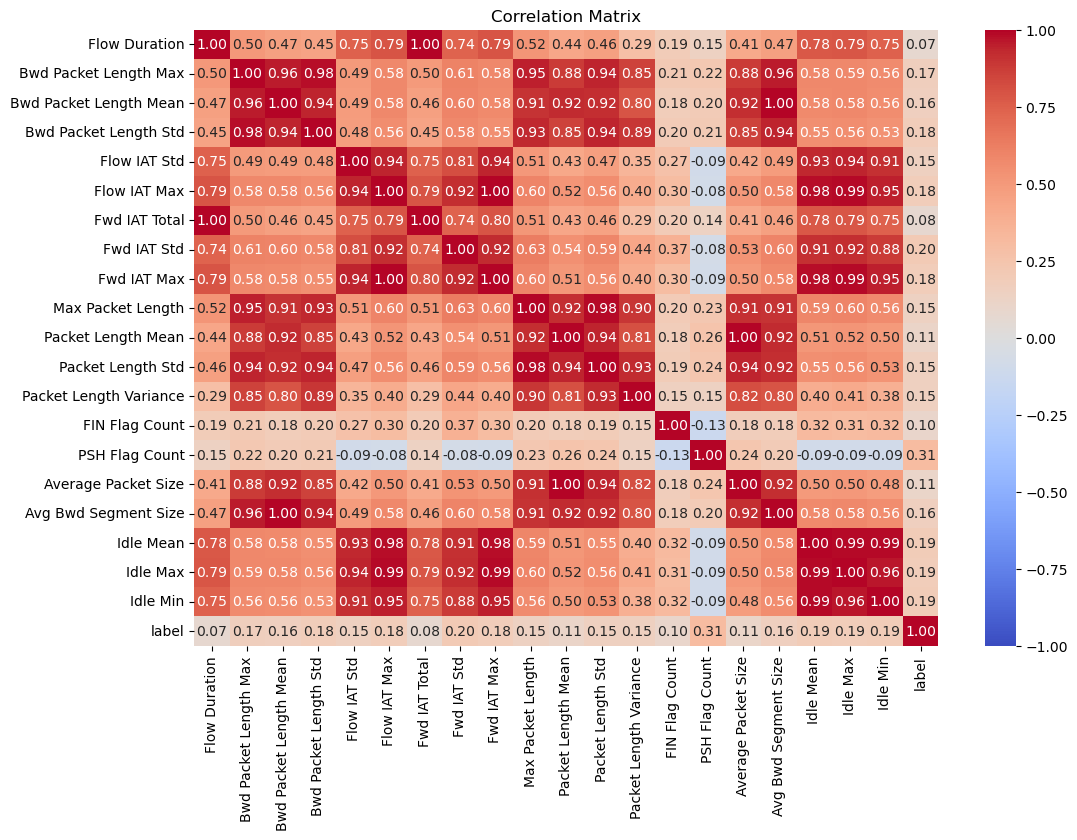

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame `df` containing the features
correlation_matrix = df_new.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


In [35]:
df_new.loc[:, 'label'] = df['Label']


In [36]:
X1=df_new.iloc[:,:-1].values
y1=df_new.iloc[:,-1].values

In [37]:
len(X1[0])

20

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [39]:
X_test.shape, y_test.shape

((798114, 20), (798114,))

In [41]:
ann = Sequential()
ann.add(Dense(units=20,activation='relu'))
ann.add(Dense(units=20,activation='relu'))
ann.add(Dense(units=12,activation='softmax'))
ann.compile(optimizer ='adam' , loss='sparse_categorical_crossentropy' , metrics= ['accuracy'])


In [76]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [90]:
ann.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=[early_stopping])


NameError: name 'ann' is not defined

In [44]:
from sklearn.metrics import accuracy_score

# Make predictions on the test set (X_test)
predictions = ann.predict(X_test)

# For multi-class classification, get the predicted class (index of highest probability)
predicted_classes = np.argmax(predictions, axis=1)

# Compare the predicted labels with the true labels (y_test)
accuracy = accuracy_score(y_test, predicted_classes)

# Print accuracy
print("Accuracy:", accuracy)

24942/24942 ━━━━━━━━━━━━━━━━━━━━ 4s 165us/step
Accuracy: 0.8584237339527937


In [48]:
from sklearn.metrics import confusion_matrix  # Import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

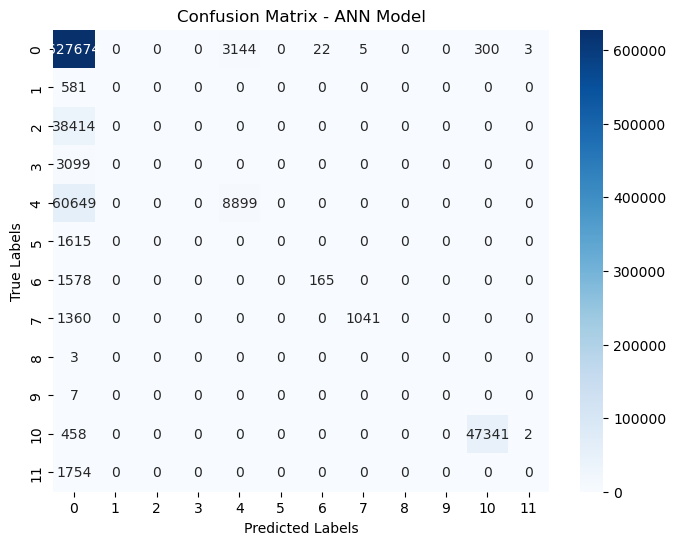

In [50]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - ANN Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [52]:
class ClassificationModel:
    def __init__(self, numerical_feature_count, num_classes):
        """
        Initializes the ClassificationModel class.
        
        :param numerical_feature_count: Number of numerical features.
        :param num_classes: Number of classes in the target variable.
        """
        self.numerical_feature_count = numerical_feature_count
        self.num_classes = num_classes
        self.model = self._build_model()

    def _build_model(self):
        """
        Builds the TensorFlow model for classification tasks.
        
        :return: Compiled TensorFlow model.
        """
        # Numerical input
        numerical_input = Input(shape=(self.numerical_feature_count,), name="numerical_input")
        x = BatchNormalization()(numerical_input)  # Normalize numerical inputs

        # Fully connected layers
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu')(x)

        # Output layer
        output = Dense(self.num_classes, activation='softmax', name="output")(x)

        # Create model
        model = Model(inputs=numerical_input, outputs=output)
        
        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

    def summary(self):
        """Prints the summary of the model."""
        self.model.summary()

numerical_feature_count = 20
num_classes = 12

model = ClassificationModel(numerical_feature_count, num_classes).model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ numerical_input (InputLayer)    │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,500 (52.73 KB)

 Trainable params: 13,460 (52.58 KB)

 Non-trainable params: 40 (160.00 B)

In [ ]:
#training the model on training set
model.fit(X_train,y_train,batch_size=32,epochs=100,callbacks=[early_stopping])

Epoch 1/100
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 26s 434us/step - accuracy: 0.8995 - loss: 0.3094
Epoch 2/100
  329/58196 ━━━━━━━━━━━━━━━━━━━━ 26s 458us/step - accuracy: 0.9099 - loss: 0.2583

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


58196/58196 ━━━━━━━━━━━━━━━━━━━━ 24s 413us/step - accuracy: 0.9130 - loss: 0.2514
Epoch 3/100
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 24s 410us/step - accuracy: 0.9150 - loss: 0.2448
Epoch 4/100
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 24s 410us/step - accuracy: 0.9154 - loss: 0.2426
Epoch 5/100
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 24s 409us/step - accuracy: 0.9160 - loss: 0.2408
Epoch 6/100
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 24s 409us/step - accuracy: 0.9163 - loss: 0.2401
Epoch 7/100
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 24s 409us/step - accuracy: 0.9162 - loss: 0.2399
Epoch 8/100
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 24s 411us/step - accuracy: 0.9161 - loss: 0.2403
Epoch 9/100
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 24s 418us/step - accuracy: 0.9161 - loss: 0.2403
Epoch 10/100
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 26s 448us/step - accuracy: 0.9164 - loss: 0.2399
Epoch 11/100
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 24s 416us/step - accuracy: 0.9162 - loss: 0.2389
Epoch 12/100
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 24s 420us/step - accurac

In [ ]:
# Evaluate the model on the test set (X_test, y_test)
loss, accuracy = model.evaluate(X_test, y_test)

# Print the loss and accuracy
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - Classification Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# #gives the probabibility wheather the customer will churn or not
# print(model.predict([[3268,72,72,0,0,0,0,201,72,32,3268,72,72,0,0,0,0,201,72,32]]))

In [78]:
X_train = X_train.reshape(X_train.shape[0],1, X_train.shape[1])  # (samples, timesteps, features)
#X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)          # Reshape validation data similarly
X_test = X_test.reshape(X_test.shape[0], 1,X_test.shape[1])       # Reshape test data similarly


In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the BiGRU Model
def build_bigru_model(input_shape, num_classes=12):
    model = Sequential()
    
    # Add a Bidirectional GRU layer
    model.add(Bidirectional(GRU(units=64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    
    # Add another BiGRU layer
    model.add(Bidirectional(GRU(units=32)))
    model.add(Dropout(0.3))
    
    # Add BatchNormalization to stabilize the model
    model.add(BatchNormalization())

    # Output Layer: 12 units for classification with softmax activation
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [82]:
# Define input shape (for example, (timesteps, features))
input_shape = (X_train.shape[1], X_train.shape[2])  # Modify based on your input shape

# Build the model
model = build_bigru_model(input_shape=input_shape, num_classes=12)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Fit the model on the training data
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=10, 
                    callbacks=[early_stopping])


Epoch 1/10
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 85s 1ms/step - accuracy: 0.8797 - loss: 0.3694
Epoch 2/10
  101/58196 ━━━━━━━━━━━━━━━━━━━━ 1:28 2ms/step - accuracy: 0.8852 - loss: 0.3388

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


58196/58196 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - accuracy: 0.8970 - loss: 0.3017
Epoch 3/10
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - accuracy: 0.8967 - loss: 0.3006
Epoch 4/10
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - accuracy: 0.8977 - loss: 0.2948
Epoch 5/10
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - accuracy: 0.8981 - loss: 0.2972
Epoch 6/10
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - accuracy: 0.8949 - loss: 0.3028
Epoch 7/10
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - accuracy: 0.8948 - loss: 0.3015
Epoch 8/10
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - accuracy: 0.8948 - loss: 0.3005
Epoch 9/10
58196/58196 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - accuracy: 0.8973 - loss: 0.2973
Epoch 10/10
 5767/58196 ━━━━━━━━━━━━━━━━━━━━ 1:21 2ms/step - accuracy: 0.8965 - loss: 0.3026

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

# Print the results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


In [ ]:
lr = LinearRegression()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size=0.3, random_state=42)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


In [ ]:
lr.fit(X_train,y_train)

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
print("Mean Squared Error:",  mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

In [ ]:
model.save("model.h5")